# Convolutional Neural Networks Part 2:

 - Methods To Handle Overfitting

### 2nd Method: Batch Normalization Without Data Augmentation:

 - Adds a 'normalization layer' after each convolutional layer.
     - Between Convolutional Layer and Activation Layer.
     - No need for bias in the Convolutional Layer.
 - Model Converges Much Faster In Training
     - Can Use higher Learning Rates.

#### GPU Settings:

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

#### Check GPU Availibility & Set Memory Limit:

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)]) # Alt: 1792 MB, 2048 MB
    except RuntimeError as e:
        print(e)

tf.config.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### Import Libraries:

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from random import randint
from tensorflow.keras import layers, regularizers
from keras.models import Sequential, load_model
from keras.datasets import cifar10
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from keras.applications.vgg16 import preprocess_input
from keras.layers import Dense, Conv2D, Flatten, Dropout, Activation, MaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score

#### Define Functions For Plotting:

In [4]:
# plot training accuracy and loss
def plotCurve(trainingAccuracy, trainingLoss):
    epochs = np.arange(trainingLoss.shape[0])
    #print(epochs)
    plt.figure(figsize = [12, 6])
    plt.subplot(1, 2, 1)
    plt.plot(epochs, trainingAccuracy)
    #plt.axis([-1, 2, -1, 2])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, trainingLoss)
    plt.xlabel('Epoch')
    plt.ylabel('Binary CrossEntropy Loss')
    plt.title('Training Loss')
    plt.show()

# Plot Features of CIFAR-10 data
def feat_plot(features, labels, classes, title):
    for class_i in classes:
        plt.plot(features[labels[:] == classes[class_i], 0],
                 features[labels[:] == classes[class_i], 1], 'o', markersize = 5)
        # plt.axis([-2, 2, -2, 2])
        plt.xlabel('X: Feature 1')
        plt.ylabel('Y: Feature 2')
        plt.title(title)
        plt.legend(['Class ' + str(classes[class_i]) for class_i in classes])
    plt.show()

def plotBothCurves(trainingAccuracy, trainingLoss, validAccuracy, validLoss):
    epochs = np.arange(trainingLoss.shape[0])
    epochsSaved = np.arange(validLoss.shape[0])
    #print(epochs)
    # 1st Subplot: Accuracy
    plt.figure(figsize = [12, 6])
    plt.subplot(1, 2, 1)
    plt.plot(epochs, trainingAccuracy)
    plt.plot(epochsSaved, validAccuracy) # Saved Best Value
    plt.legend(['Training', 'Validation'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    # 2nd Subplot: Training Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, trainingLoss)
    plt.plot(epochsSaved, validLoss)
    plt.legend(['Training', 'Validation'])
    plt.xlabel('Epoch')
    plt.ylabel('Binary CrossEntropy Loss')
    plt.title('Training Loss')
    plt.show()

# Plot CIFAR-10 Data In Subplots
def img_plt(img, label):
    plt.figure(figsize=(12, 5.5))
    for i in range (1, 11):
        plt.subplot(2, 5, i)
        plt.imshow(img[i - 1, :, :], cmap = 'gray')
        plt.title('Label: ' + str(label[i - 1]))
    plt.show()

def plotEverything(model_hist):
    trainAcc = np.array(model_hist.history['accuracy'])
    trainLoss = np.array(model_hist.history['loss'])
    validAcc = np.array(model_hist.history['val_accuracy'])
    validLoss = np.array(model_hist.history['val_loss'])

    plotBothCurves(trainAcc, trainLoss, validAcc, validLoss)

    trainScore = [trainAcc[-1], trainLoss[-1]]
    print(f'\nTraining Accuracy: {round(trainScore[0], 5) * 100} %')
    print(f'Training Loss: {round(trainScore[1], 4)}\n')

    valScore = [validAcc[-1], validLoss[-1]]
    print(f'\nValidation Accuracy: {round(valScore[0], 5) * 100} %')
    print(f'Validation Loss: {round(valScore[1], 4)}\n')

#### Import Data:

 - Each of the 50,000 Images is 32 x 32 pixels x 3 RGB values
     - Each Image is 3D.

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

classes = np.arange(10)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


#### Randomize & Select 20% of Images For Validation:

In [6]:
num_train_img = x_train.shape[0]
train_ind = np.arange(0, num_train_img)
train_ind_s = np.random.permutation(train_ind)
print(train_ind)
print(train_ind_s, '\n')

x_train = x_train[train_ind_s,:,:,:]
y_train = y_train[train_ind_s]
print(x_train.shape)
print(y_train.shape, '\n')

x_val = x_train[0:int(0.2 * num_train_img),:,:,:]
y_val = y_train[0:int(0.2 * num_train_img)]
print(x_val.shape)
print(y_val.shape, '\n')

x_train = x_train[int(0.2 * num_train_img):,:,:]
y_train = y_train[int(0.2 * num_train_img):]
print(x_train.shape)
print(y_train.shape, '\n')

[    0     1     2 ... 49997 49998 49999]
[24468 31581  1801 ... 40607 10014 49466] 

(50000, 32, 32, 3)
(50000, 1) 

(10000, 32, 32, 3)
(10000, 1) 

(40000, 32, 32, 3)
(40000, 1) 



#### Plot 1st 10 Images From Randomized Data:

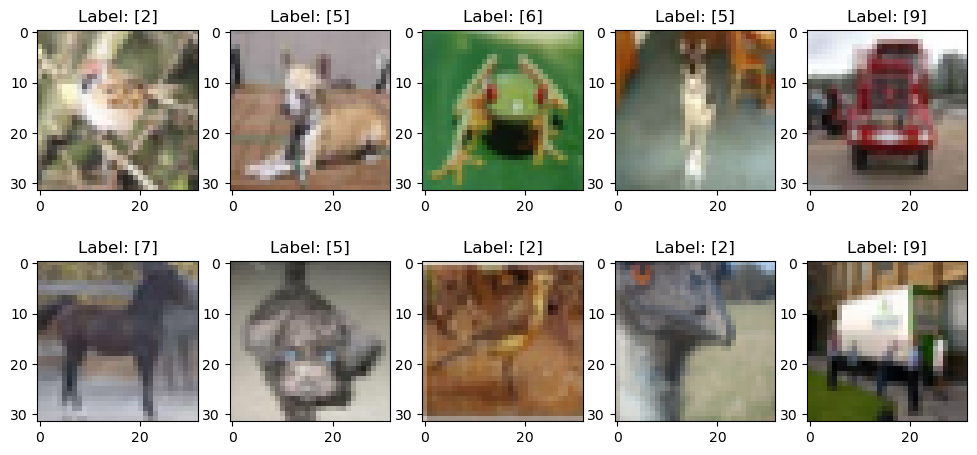

In [7]:
img_plt(x_train[0:10,:,:,:], y_train[0:10]) # plot the images

#### Scaling The Images to $ [0, \ 1] $:

In [8]:
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_val /= 255
x_test /= 255

#### Convert Class Vectors to Binary Class Matrices:

In [9]:
y_train_c = to_categorical(y_train, len(classes))
y_val_c = to_categorical(y_val, len(classes))
y_test_c = to_categorical(y_test, len(classes))

#### Define The Model:

In [10]:
model5 = Sequential()
model5.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', input_shape=x_train.shape[1:], use_bias=False))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(Conv2D(32, (3, 3), padding='same', use_bias=False))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size=(2, 2))) # MaxPooling2D Layer or AveragePooling2D Layer

model5.add(Conv2D(64, (3, 3), padding='same', use_bias=False))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(Conv2D(64, (3, 3), padding='same', use_bias=False))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))

model5.add(Flatten()) # Optional:Flattens 2D images to 1D Array
model5.add(Dense(units=512))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(Dropout(0.5)) # Helps to reduce overfitting
model5.add(Dense(units=len(classes)))
model5.add(BatchNormalization())
model5.add(Activation('softmax'))
model5.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        864       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9216      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0

#### Compile The Model:

 - Increase Learning Rate 10x: 0.001 to 0.01
 - Increase Batch Size 4x: 16 to 64

Epoch 1/50
625/625 [==============================] - 30s 38ms/step - loss: 1.5218 - accuracy: 0.4575 - val_loss: 1.0926 - val_accuracy: 0.6148
Epoch 2/50
625/625 [==============================] - 23s 38ms/step - loss: 0.9017 - accuracy: 0.6854 - val_loss: 1.1599 - val_accuracy: 0.6084
Epoch 3/50
625/625 [==============================] - 28s 46ms/step - loss: 0.7235 - accuracy: 0.7455 - val_loss: 0.9459 - val_accuracy: 0.6725
Epoch 4/50
625/625 [==============================] - 25s 40ms/step - loss: 0.6138 - accuracy: 0.7864 - val_loss: 0.7751 - val_accuracy: 0.7335
Epoch 5/50
625/625 [==============================] - 26s 42ms/step - loss: 0.5040 - accuracy: 0.8252 - val_loss: 0.7657 - val_accuracy: 0.7446
Epoch 6/50
625/625 [==============================] - 17s 27ms/step - loss: 0.4341 - accuracy: 0.8488 - val_loss: 0.9409 - val_accuracy: 0.6925
Epoch 7/50
625/625 [==============================] - 25s 40ms/step - loss: 0.3548 - accuracy: 0.8771 - val_loss: 0.9252 - val_accuracy:

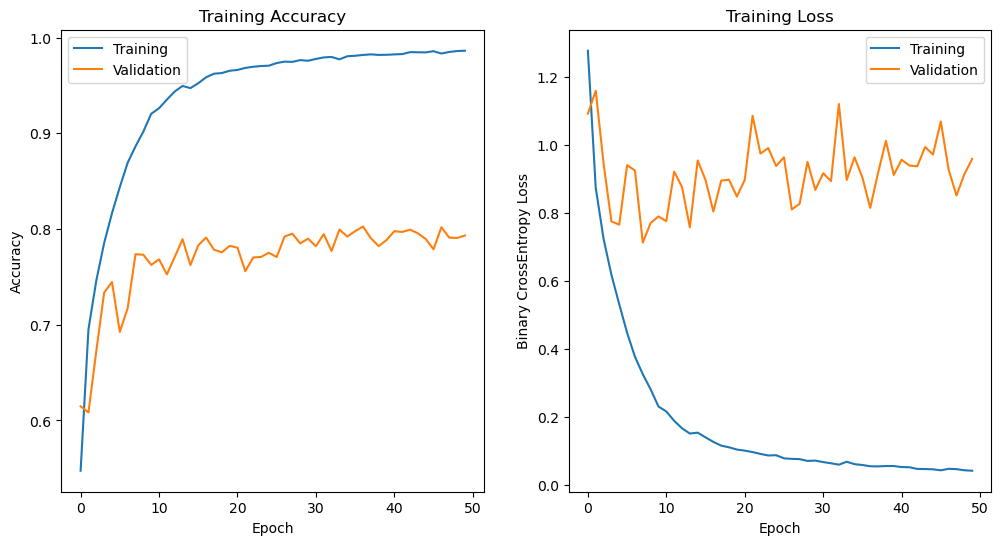


Training Accuracy: 98.61999999999999 %
Training Loss: 0.0412


Validation Accuracy: 79.32000000000001 %
Validation Loss: 0.9593



In [11]:
save_path5 = '../assets/Lecture7/model5_ckpt.h5'
callbacks_save5 = ModelCheckpoint(save_path5, monitor='val_loss', verbose=0, save_best_only=True, save_freq='epoch')

opt5 = tf.keras.optimizers.Adam(learning_rate=0.01)
model5.compile(loss='categorical_crossentropy', optimizer=opt5, metrics=['accuracy'])

history5 = model5.fit(x_train, y_train_c, batch_size=64, 
                      epochs=50, verbose=1, validation_data=(x_val, y_val_c), 
                      callbacks=[callbacks_save5])

plotEverything(history5)

#### Load Best Model & Evaluate:

In [12]:
model5a = load_model(save_path5)

score5a = model5a.evaluate(x_train, y_train_c)
print(f'Total Loss From Training Set: {score5a[0]}')
print(f'Accuracy From Training Set: {score5a[1] * 100} %\n')

score5b = model5a.evaluate(x_val, y_val_c)
print(f'Total Loss From Validation Set: {score5b[0]}')
print(f'Accuracy From Validation Set: {score5b[1] * 100} %\n')

score5c = model5a.evaluate(x_test, y_test_c)
print(f'Total Loss From Testing Set: {score5c[0]}')
print(f'Accuracy From Testing Set: {score5c[1] * 100} %\n')

1250/1250 [==============================] - 11s 7ms/step - loss: 0.1830 - accuracy: 0.9447
Total Loss From Training Set: 0.1830059438943863
Accuracy From Training Set: 94.46750283241272 %

313/313 [==============================] - 4s 12ms/step - loss: 0.7129 - accuracy: 0.7737
Total Loss From Validation Set: 0.7128925919532776
Accuracy From Validation Set: 77.36999988555908 %

313/313 [==============================] - 4s 11ms/step - loss: 0.7266 - accuracy: 0.7724
Total Loss From Testing Set: 0.7266178727149963
Accuracy From Testing Set: 77.24000215530396 %



#### Predict Class Of Held Out Samples:

In [13]:
test_class2_prob = model5.predict(x_test)
test_labels2 = np.argmax(test_class2_prob, axis=1)
print(f'The Accuracy Predicting The Test Set is: {accuracy_score(test_labels2, y_test) * 100} %\n')
conf_matrix2 = confusion_matrix(test_labels2, y_test)

colLabels2 = ['Pred Plane', 'Pred Car', 'Pred Bird', 'Pred Cat', 'Pred Deer',
             'Pred Dog', 'Pred Frog', 'Pred Horse', 'Pred Ship', 'Pred Truck']
rowLabels2 = ['Actual Plane', 'Actual Car', 'Actual Bird', 'Actual Cat', 'Actual Deer',
             'Actual Dog', 'Actual Frog', 'Actual Horse', 'Actual Ship', 'Actual Truck']

fancyMatrix2 = pd.DataFrame(conf_matrix2, columns=colLabels2, index=rowLabels2,)
display(fancyMatrix2)

The Accuracy Predicting The Test Set is: 79.09 %



,Pred Plane,Pred Car,Pred Bird,Pred Cat,Pred Deer,Pred Dog,Pred Frog,Pred Horse,Pred Ship,Pred Truck
Actual Plane,829,12,43,28,13,10,4,21,37,23
Actual Car,13,905,3,8,9,3,1,4,12,61
Actual Bird,46,5,739,93,72,59,48,43,13,7
Actual Cat,6,5,31,610,54,133,36,34,3,11
Actual Deer,14,2,57,31,733,32,8,51,0,1
Actual Dog,2,5,43,123,27,711,11,70,4,8
Actual Frog,7,7,58,67,59,22,880,8,6,8
Actual Horse,1,0,7,12,22,20,1,749,1,3
Actual Ship,68,26,14,18,10,7,11,9,916,41
Actual Truck,14,33,5,10,1,3,0,11,8,837
